# Skin Lesion Classification

In [1]:
!pip install torch torchvision opencv-python scikit-image scikit-learn pandas numpy matplotlib seaborn pillow statsmodels segmentation-models-pytorch torch-lr-finder

In [2]:
# Skin Lesion Classification System
# Computer Vision approach for melanoma detection using deep learning

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
import warnings
warnings.filterwarnings('ignore')

# Computer Vision Libraries
import cv2
import skimage
from skimage import color
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, closing, disk
from skimage.segmentation import clear_border

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
import torchvision.transforms as T

import segmentation_models_pytorch as smp

# Evaluation Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import statsmodels.api as sm

# Check device availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"Using device: {device}")


Using device: mps


In [3]:
DATA_DIR = 'ISIC-images'
METADATA_PATH = 'ham10000_metadata_2025-11-04.csv'
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
MODEL_NAME = 'resnet18'
USE_SEGMENTATION = False
NUM_WORKERS = 4

seed = 42

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Preparation

In [4]:
df = pd.read_csv(METADATA_PATH)

In [5]:
df.head()

,isic_id,attribution,copyright_license,age_approx,anatom_site_general,anatom_site_special,concomitant_biopsy,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_confirm_type,image_manipulation,image_type,lesion_id,melanocytic,sex
0,ISIC_0024306,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,45.0,NaN,NaN,False,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,NaN,dermoscopic,IL_7252831,True,male
1,ISIC_0024307,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,50.0,lower extremity,NaN,False,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,NaN,dermoscopic,IL_6125741,True,male
2,ISIC_0024308,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,55.0,NaN,NaN,False,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,NaN,dermoscopic,IL_3692653,True,female
3,ISIC_0024309,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,40.0,NaN,NaN,False,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,NaN,dermoscopic,IL_0959663,True,male
4,ISIC_0024310,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,60.0,anterior torso,NaN,True,Malignant,Malignant melanocytic proliferations (Melanoma),"Melanoma, NOS",histopathology,NaN,dermoscopic,IL_8194852,True,male


In [6]:
df = df[["isic_id", "diagnosis_1"]]

In [7]:
df.head()

,isic_id,diagnosis_1
0,ISIC_0024306,Benign
1,ISIC_0024307,Benign
2,ISIC_0024308,Benign
3,ISIC_0024309,Benign
4,ISIC_0024310,Malignant


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11720 entries, 0 to 11719
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   isic_id      11720 non-null  object
 1   diagnosis_1  11720 non-null  object
dtypes: object(2)
memory usage: 183.3+ KB


In [9]:
df['diagnosis_1'].value_counts()

diagnosis_1
Benign           9415
Malignant        2156
Indeterminate     149
Name: count, dtype: int64

In [10]:
# Remove rows with Indeterminate diagnosis

df = df[df['diagnosis_1'] != 'Indeterminate']

In [11]:
df['diagnosis_1'].value_counts()

diagnosis_1
Benign       9415
Malignant    2156
Name: count, dtype: int64

In [12]:
# Add binary label column for the diagnosis

df['diagnosis_1_bin'] = df['diagnosis_1'].map({'Malignant': 1, 'Benign': 0}).astype(int)

In [13]:
df.head()

,isic_id,diagnosis_1,diagnosis_1_bin
0,ISIC_0024306,Benign,0
1,ISIC_0024307,Benign,0
2,ISIC_0024308,Benign,0
3,ISIC_0024309,Benign,0
4,ISIC_0024310,Malignant,1


In [14]:
df[df['diagnosis_1_bin'] == 1]['diagnosis_1_bin'].head(4)

4     1
7     1
9     1
17    1
Name: diagnosis_1_bin, dtype: int64

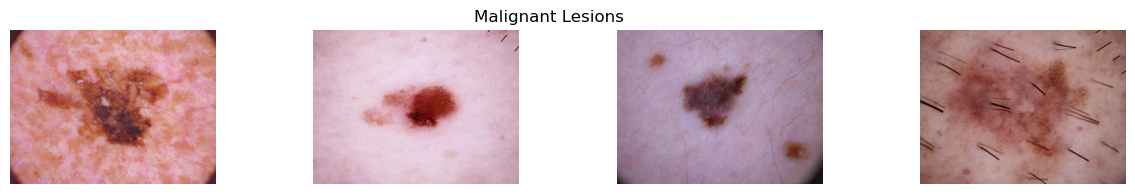

In [15]:
# Display a Malignant images

fig, axes = plt.subplots(1, 4, figsize = (15, 2))
fig.suptitle('Malignant Lesions')
idx = 0
for index, row in df[df['diagnosis_1_bin'] == 1].head(4).iterrows():
    file_path = f'ISIC-images/{row['isic_id']}.jpg'
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(img_rgb)
    axes[idx].axis("off")
    idx += 1
plt.show()

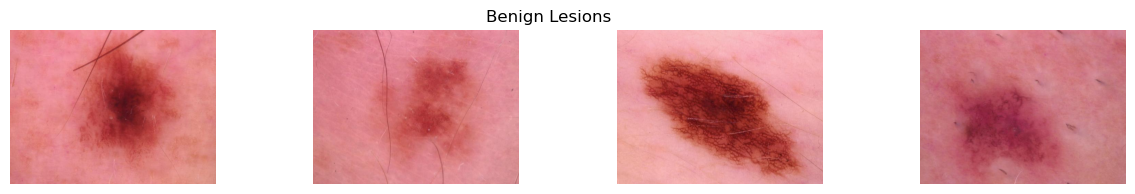

In [16]:
# Display a Benign images

fig, axes = plt.subplots(1, 4, figsize = (15, 2))
fig.suptitle('Benign Lesions')
idx = 0
for index, row in df[df['diagnosis_1_bin'] == 0].head(4).iterrows():
    file_path = f'ISIC-images/{row['isic_id']}.jpg'
    img = cv2.imread(file_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(img_rgb)
    axes[idx].axis("off")
    idx += 1
plt.show()

## Test-Train Split

In [17]:
df.head()

,isic_id,diagnosis_1,diagnosis_1_bin
0,ISIC_0024306,Benign,0
1,ISIC_0024307,Benign,0
2,ISIC_0024308,Benign,0
3,ISIC_0024309,Benign,0
4,ISIC_0024310,Malignant,1


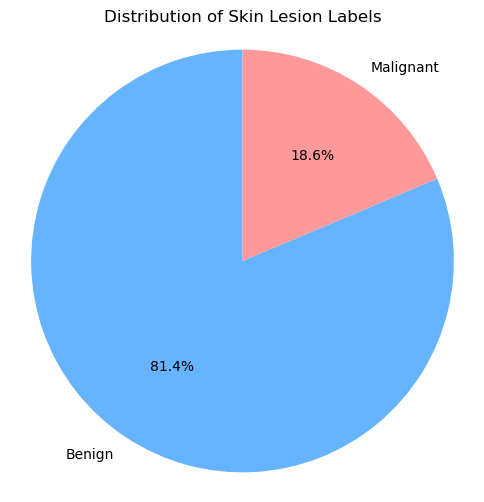

In [18]:
# Example using your DataFrame 'df'
label_counts = df['diagnosis_1'].value_counts()
labels = label_counts.index
sizes = label_counts.values

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title("Distribution of Skin Lesion Labels")
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle
plt.show()

In [19]:
features = df['isic_id']
target = df['diagnosis_1_bin']

In [20]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=42)

In [21]:
x_train.shape, x_test.shape

((9835,), (1736,))

## Custom Dataset

In [22]:
class SkinLesionDataset(Dataset):
    def __init__(self, ids, labels, img_dir, transform=None, unet_model=None, unet_input_size=384):
        self.ids = ids.values
        self.labels = labels.values
        self.img_dir = img_dir
        self.transform = transform
        self.unet_model = unet_model
        self.unet_input_size = unet_input_size

    def __len__(self):
        return len(self.ids)

    # def segment_lesion(self, image, min_size=500, selem_radius=5):
    #     """Segment lesion using skimage.morphology"""
    #     gray = color.rgb2gray(image)
    #     thresh = threshold_otsu(gray)
    #     binary = gray < thresh
    #     selem = disk(selem_radius)
    #     binary = closing(binary, selem)
    #     binary = remove_small_objects(binary, min_size=min_size)
    #     binary = clear_border(binary)
    #     masked_image = image.copy()
    #     masked_image[~binary] = 0
    #     return masked_image

    def crude_lesion_mask(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Otsu threshold
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
        # Morphological cleanup
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    
        return mask


    def apply_mask(self, img, mask):
        return cv2.bitwise_and(img, img, mask=mask)


    def preprocess_image(self, img):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        mask = self.crude_lesion_mask(img)
        img = self.apply_mask(img, mask)

        return img

    def apply_unet_mask(self, img):
        """
        1) Resize to high resolution for U-Net
        2) Predict mask
        3) Apply mask
        4) Return masked image at original size
        """
        # Resize for UNet
        h = self.unet_input_size
        img_resized = cv2.resize(img, (h, h))
        img_tensor = T.ToTensor()(img_resized).unsqueeze(0).to(device)

        with torch.no_grad():
            mask = self.unet_model(img_tensor)     # (1,1,H,W)
            mask = torch.sigmoid(mask)
            mask = (mask > 0.5).float() * 255

        mask_np = mask.squeeze().cpu().numpy().astype(np.uint8)

        # Apply mask on resized image
        masked = cv2.bitwise_and(img_resized, img_resized, mask=mask_np)

        # Resize masked back to 224x224 for classifier input
        masked = cv2.resize(masked, (224, 224))

        return masked
    

    def __getitem__(self, idx):
        image_id = self.ids[idx]
        img_path = os.path.join(DATA_DIR, image_id + ".jpg")
    
        # Load BGR → convert to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        # Resize once (U-Net input size)
        img = cv2.resize(img, (224, 224))
    
        # Apply U-Net segmentation
        if self.unet_model is not None:
            with torch.no_grad():
                tensor = T.ToTensor()(img).unsqueeze(0).to(device)
                mask = self.unet_model(tensor)
                mask = (torch.sigmoid(mask) > 0.5).float() * 255
                mask = mask.squeeze().cpu().numpy().astype(np.uint8)
    
            # Apply mask
            img = cv2.bitwise_and(img, img, mask=mask)
    
        # Convert mask-applied RGB numpy → PIL
        image = Image.fromarray(img)
    
        label = torch.tensor(self.labels[idx]).float()
    
        # Apply augmentations AFTER segmentation
        if self.transform:
            image = self.transform(image)
    
        return image, label

In [23]:
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.70, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(
        brightness=0.25,
        contrast=0.25,
        saturation=0.25,
        hue=0.02,
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

test_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [24]:
# Load U-Net
unet_model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g., resnet34, efficientnet-b0
    encoder_weights="imagenet",     # use pretrained weights
    in_channels=3,                  # RGB input
    classes=1                       # binary mask
).to(device)
unet_model.to(device)
unet_model.eval()

# Freeze U-Net
for p in unet_model.parameters():
    p.requires_grad = False

# Create datasets
train_dataset = SkinLesionDataset(x_train, y_train, "images", train_tfms, unet_model)
test_dataset  = SkinLesionDataset(x_test, y_test, "images", test_tfms, unet_model)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Load ResNet18

In [25]:
# model = models.resnet34(pretrained=True)
model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

model.fc = nn.Linear(model.fc.in_features, 1)

model = model.to(device)

## Loss and Optimizer

In [26]:
# Compute class weights
num_benign = (df['diagnosis_1_bin'] == 0).sum()
num_malignant = (df['diagnosis_1_bin'] == 1).sum()

# Weight for positive class (malignant)
pos_weight = torch.tensor([num_benign / num_malignant], dtype=torch.float32).to(device)
print("Positive class weight:", pos_weight.item())

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# learning_rate = 1e-3
# learning_rate = 5e-4
learning_rate = 1e-4
# learning_rate = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Positive class weight: 4.366883277893066


## Training Loop

In [27]:
print(device)

mps


In [46]:
epochs = 50

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        # Move to device first
        images = images.to(device)
        labels = labels.to(device).view(-1, 1).float()  # reshape and convert to float

        optimizer.zero_grad()
        outputs = model(images)                  # outputs are on same device as model
        loss = criterion(outputs, labels)        # works correctly now
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")
        

Epoch 1/10, Loss: 0.3614
Epoch 2/10, Loss: 0.3580
Epoch 3/10, Loss: 0.3388
Epoch 4/10, Loss: 0.3408
Epoch 5/10, Loss: 0.3222
Epoch 6/10, Loss: 0.3093
Epoch 7/10, Loss: 0.3235
Epoch 8/10, Loss: 0.3164
Epoch 9/10, Loss: 0.3087
Epoch 10/10, Loss: 0.2876


## Evaluation

In [47]:
model.eval()
y_true = []
y_pred = []
y_pred_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).view(-1,1).float()

        outputs = model(images)
        probs = torch.sigmoid(outputs)

        predicted = (probs > 0.5).float()  # binary prediction

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_pred_prob.extend(probs.cpu().numpy().flatten())  # <- flatten here

## Metrics

In [48]:
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)      # Sensitivity
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob)

# Specificity
TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP)

# PRINT ALL METRICS
print("\n✅ CONFUSION MATRIX:\n", cm)
print("\n✅ CLASSIFICATION REPORT:\n", classification_report(y_true, y_pred))

print(f"✅ Accuracy     : {accuracy:.4f}")
print(f"✅ Precision    : {precision:.4f}")
print(f"✅ Recall (TPR) : {recall:.4f}")
print(f"✅ Specificity  : {specificity:.4f}")
print(f"✅ F1 Score     : {f1:.4f}")
print(f"✅ ROC-AUC      : {auc:.4f}")


✅ CONFUSION MATRIX:
 [[1251  141]
 [ 106  238]]

✅ CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       0.92      0.90      0.91      1392
         1.0       0.63      0.69      0.66       344

    accuracy                           0.86      1736
   macro avg       0.77      0.80      0.78      1736
weighted avg       0.86      0.86      0.86      1736

✅ Accuracy     : 0.8577
✅ Precision    : 0.6280
✅ Recall (TPR) : 0.6919
✅ Specificity  : 0.8987
✅ F1 Score     : 0.6584
✅ ROC-AUC      : 0.9119


## Apply new threshold

In [49]:
precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_prob)

# Compute F1 score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)  # add small epsilon to avoid div by zero

# Find threshold with max F1
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Optimal threshold: {best_threshold:.4f}")
print(f"F1 score at optimal threshold: {best_f1:.4f}")



# Convert probabilities to binary predictions using the new threshold
y_pred_optimal = (np.array(y_pred_prob) >= best_threshold).astype(int)

# Now compute metrics with optimal threshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_true, y_pred_optimal)
precision = precision_score(y_true, y_pred_optimal)
recall = recall_score(y_true, y_pred_optimal)
f1 = f1_score(y_true, y_pred_optimal)
auc = roc_auc_score(y_true, y_pred_optimal)
cm = confusion_matrix(y_true, y_pred_optimal)

print("✅ CONFUSION MATRIX:\n", cm)
print(f"✅ Accuracy : {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall   : {recall:.4f}")
print(f"✅ F1 Score : {f1:.4f}")
print(f"✅ ROC-AUC      : {auc:.4f}")

Optimal threshold: 0.3462
F1 score at optimal threshold: 0.6794
✅ CONFUSION MATRIX:
 [[1217  175]
 [  77  267]]
✅ Accuracy : 0.8548
✅ Precision: 0.6041
✅ Recall   : 0.7762
✅ F1 Score : 0.6794
✅ ROC-AUC      : 0.8252


## Applying threshold where Recall >= 0.9

In [50]:
precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_prob)

# Find thresholds where recall >= 0.9
valid_idx = np.where(recalls >= 0.9)[0]

# Pick the threshold with the highest precision among them
best_idx = valid_idx[np.argmax(precisions[valid_idx])]
best_threshold_recall90 = thresholds[best_idx]
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]

print(f"Threshold with recall ≥ 0.9: {best_threshold_recall90:.4f}")
print(f"Precision at this threshold : {best_precision:.4f}")
print(f"Recall at this threshold    : {best_recall:.4f}")

Threshold with recall ≥ 0.9: 0.0612
Precision at this threshold : 0.4613
Recall at this threshold    : 0.9012


In [51]:
# Convert probabilities to binary predictions
y_pred_optimal = (np.array(y_pred_prob) >= best_threshold_recall90).astype(int)

accuracy = accuracy_score(y_true, y_pred_optimal)
precision = precision_score(y_true, y_pred_optimal)
recall = recall_score(y_true, y_pred_optimal)
f1 = f1_score(y_true, y_pred_optimal)
auc = roc_auc_score(y_true, y_pred_optimal)
cm = confusion_matrix(y_true, y_pred_optimal)

print("✅ CONFUSION MATRIX:\n", cm)
print(f"✅ Accuracy : {accuracy:.4f}")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall   : {recall:.4f}")
print(f"✅ F1 Score : {f1:.4f}")
print(f"✅ ROC-AUC      : {auc:.4f}")

✅ CONFUSION MATRIX:
 [[1030  362]
 [  34  310]]
✅ Accuracy : 0.7719
✅ Precision: 0.4613
✅ Recall   : 0.9012
✅ F1 Score : 0.6102
✅ ROC-AUC      : 0.8206
